In [4]:
!pip install opendatasets --upgrade --quiet

# EJERCICIO 2
## Grammar and Online Product Reviews

### Importación de librerias

In [35]:

import pandas as pd
import os
import zipfile
import matplotlib.pyplot as plt
from matplotlib.image import imread
import random

from os import listdir
import shutil
import numpy as np
import keras.preprocessing.image as kerasImg
import keras.layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras import ops
import nltk
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import re
from collections import Counter
from wordcloud import WordCloud
from nltk.corpus import sentiwordnet as swn
from nltk.corpus import wordnet as wn
import nltk

### Descarga de los datos

In [16]:
import opendatasets as od


dataset = "https://www.kaggle.com/datasets/datafiniti/grammar-and-online-product-reviews/data"
od.download(dataset)


Skipping, found downloaded files in "./grammar-and-online-product-reviews" (use force=True to force download)


In [17]:
csv = "/content/grammar-and-online-product-reviews/GrammarandProductReviews.csv"
df = pd.read_csv(csv)
df.head()

,id,brand,categories,dateAdded,dateUpdated,ean,keys,manufacturer,manufacturerNumber,name,...,reviews.id,reviews.numHelpful,reviews.rating,reviews.sourceURLs,reviews.text,reviews.title,reviews.userCity,reviews.userProvince,reviews.username,upc
0,AV13O1A8GV-KLJ3akUyj,Universal Music,"Movies, Music & Books,Music,R&b,Movies & TV,Mo...",2017-07-25T00:52:42Z,2018-02-05T08:36:58Z,6.02537E+11,"602537205981,universalmusic/14331328,universal...",Universal Music Group / Cash Money,14331328,Pink Friday: Roman Reloaded Re-Up (w/dvd),...,NaN,0.0,5,https://redsky.target.com/groot-domain-api/v1/...,i love this album. it's very good. more to the...,Just Awesome,Los Angeles,NaN,Joshua,6.02537E+11
1,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",2017-07-25T05:16:03Z,2018-02-05T11:27:45Z,73416000391,lundbergorganiccinnamontoastricecakes/b000fvzw...,Lundberg,574764,Lundberg Organic Cinnamon Toast Rice Cakes,...,100209113.0,NaN,5,https://www.walmart.com/reviews/product/29775278,Good flavor. This review was collected as part...,Good,NaN,NaN,Dorothy W,73416000391
2,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",2017-07-25T05:16:03Z,2018-02-05T11:27:45Z,73416000391,lundbergorganiccinnamontoastricecakes/b000fvzw...,Lundberg,574764,Lundberg Organic Cinnamon Toast Rice Cakes,...,100209113.0,NaN,5,https://www.walmart.com/reviews/product/29775278,Good flavor.,Good,NaN,NaN,Dorothy W,73416000391
3,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",2017-07-25T16:26:19Z,2018-02-05T11:25:51Z,67981934427,"kylovesensualitypleasuregel/b00u2whx8s,0679819...",K-Y,67981934427,K-Y Love Sensuality Pleasure Gel,...,113026909.0,NaN,1,https://www.walmart.com/reviews/product/43383370,I read through the reviews on here before look...,Disappointed,NaN,NaN,Rebecca,67981934427
4,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",2017-07-25T16:26:19Z,2018-02-05T11:25:51Z,67981934427,"kylovesensualitypleasuregel/b00u2whx8s,0679819...",K-Y,67981934427,K-Y Love Sensuality Pleasure Gel,...,171267657.0,NaN,1,https://www.walmart.com/reviews/product/43383370,My husband bought this gel for us. The gel cau...,Irritation,NaN,NaN,Walker557,67981934427


In [18]:
df.columns.tolist()

['id',
 'brand',
 'categories',
 'dateAdded',
 'dateUpdated',
 'ean',
 'keys',
 'manufacturer',
 'manufacturerNumber',
 'name',
 'reviews.date',
 'reviews.dateAdded',
 'reviews.dateSeen',
 'reviews.didPurchase',
 'reviews.doRecommend',
 'reviews.id',
 'reviews.numHelpful',
 'reviews.rating',
 'reviews.sourceURLs',
 'reviews.text',
 'reviews.title',
 'reviews.userCity',
 'reviews.userProvince',
 'reviews.username',
 'upc']

### Preprocesamiento

#### Limpieza
Se le realiza la limpieza básica de las columnas a evaluar. En este caso el titulo de la review y el texto que la compone.

Lo que se le realiza es:

1. Convertir el texto completamente en minúsculas.
2. Eliminar las urls si es que tienen.
3. Eliminar las stopwords
4. Eliminar menciones, hashtags, caracteres especiales y números.

<Axes: >

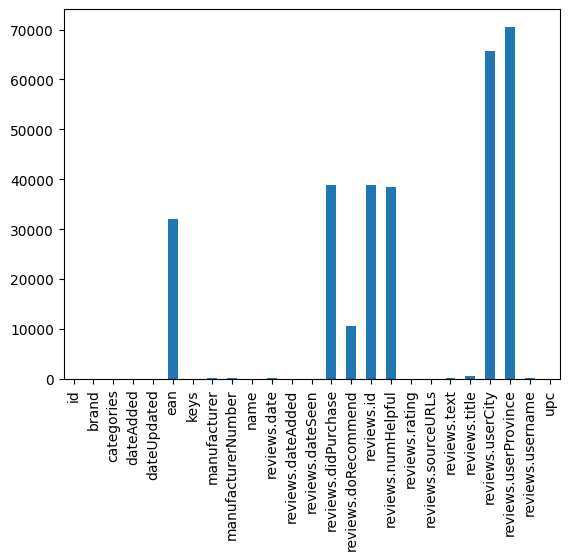

In [20]:
# Graficar los nulos
df.isnull().sum().plot(kind='bar')

In [21]:
# Rellenar los textos vacios en reviews.text y reviews.title
df['reviews.text'].fillna('', inplace=True)
df['reviews.title'].fillna('', inplace=True)

In [22]:
# Descargar stopwords si no están disponibles
nltk.download('stopwords')

# Convertir a minúsculas
df['reviews.text'] = df['reviews.text'].str.lower()

# Eliminar URLs
df['reviews.text'] = df['reviews.text'].apply(lambda x: re.sub(r'http\S+', '', x))

# Eliminar menciones, hashtags, caracteres especiales y números
df['reviews.text'] = df['reviews.text'].apply(lambda x: re.sub(r'@\w+|#\w+|\W|\d+', ' ', x))

# Eliminar stopwords
stop_words = set(stopwords.words('english'))
df['reviews.text'] = df['reviews.text'].apply(lambda x: ' '.join([word for word in x.split() if word not in stop_words]))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [24]:
df['reviews.text'].head()

,reviews.text
0,love album good hip hop side current pop sound...
1,good flavor review collected part promotion
2,good flavor
3,read reviews looking buying one couples lubric...
4,husband bought gel us gel caused irritation fe...


Se repite lo mismo con reviews.title

In [25]:
# Descargar stopwords si no están disponibles
nltk.download('stopwords')

# Convertir a minúsculas
df['reviews.title'] = df['reviews.title'].str.lower()

# Eliminar URLs
df['reviews.title'] = df['reviews.title'].apply(lambda x: re.sub(r'http\S+', '', x))

# Eliminar menciones, hashtags, caracteres especiales y números
df['reviews.title'] = df['reviews.title'].apply(lambda x: re.sub(r'@\w+|#\w+|\W|\d+', ' ', x))

# Eliminar stopwords
stop_words = set(stopwords.words('english'))
df['reviews.title'] = df['reviews.title'].apply(lambda x: ' '.join([word for word in x.split() if word not in stop_words]))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [26]:
df['reviews.title'].head()

,reviews.title
0,awesome
1,good
2,good
3,disappointed
4,irritation


### Se hace un análisis de frecuencia.

In [28]:
# Unigramas
wordsText = ' '.join(df['reviews.text']).split()
wordsTitle = ' '.join(df['reviews.title']).split()

wordsText = Counter(wordsText)
wordsTitle = Counter(wordsTitle)

In [29]:
wordsText.most_common(10)

[('great', 21142),
 ('product', 20464),
 ('movie', 20002),
 ('review', 18928),
 ('part', 18671),
 ('promotion', 17734),
 ('collected', 17726),
 ('love', 17010),
 ('use', 16080),
 ('good', 12329)]

In [30]:
wordsTitle.most_common(10)

[('great', 14369),
 ('movie', 10875),
 ('good', 5918),
 ('love', 5489),
 ('product', 5456),
 ('best', 2198),
 ('awesome', 1875),
 ('wipes', 1733),
 ('clorox', 1643),
 ('funny', 1469)]

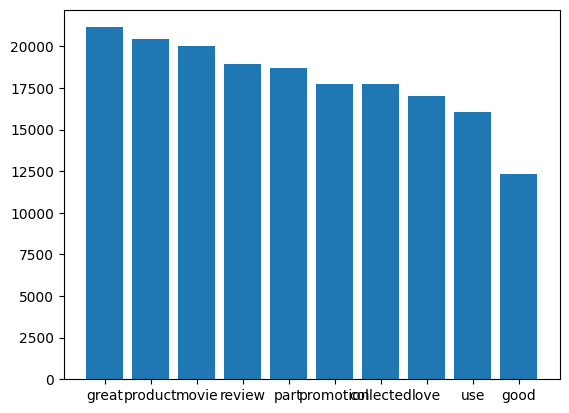

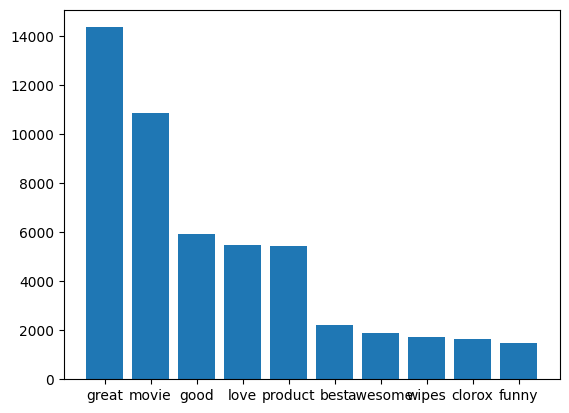

In [34]:
# Convertir frecuencia de las palabras mas repetidas en un histograma
wordsText_ = dict(wordsText.most_common(10))
wordsTitle_ = dict(wordsTitle.most_common(10))

plt.bar(range(len(wordsText_)), list(wordsText_.values()), align='center')
plt.xticks(range(len(wordsText_)), list(wordsText_.keys()))
plt.show()

print()

plt.bar(range(len(wordsTitle_)), list(wordsTitle_.values()), align='center')
plt.xticks(range(len(wordsTitle_)), list(wordsTitle_.keys()))
plt.show()


Este análisis nos muestra que en los titulos es más usual usar palabras que expresan un sentimiento o un sensación que en el mero texto. Como greate, best, love, good.

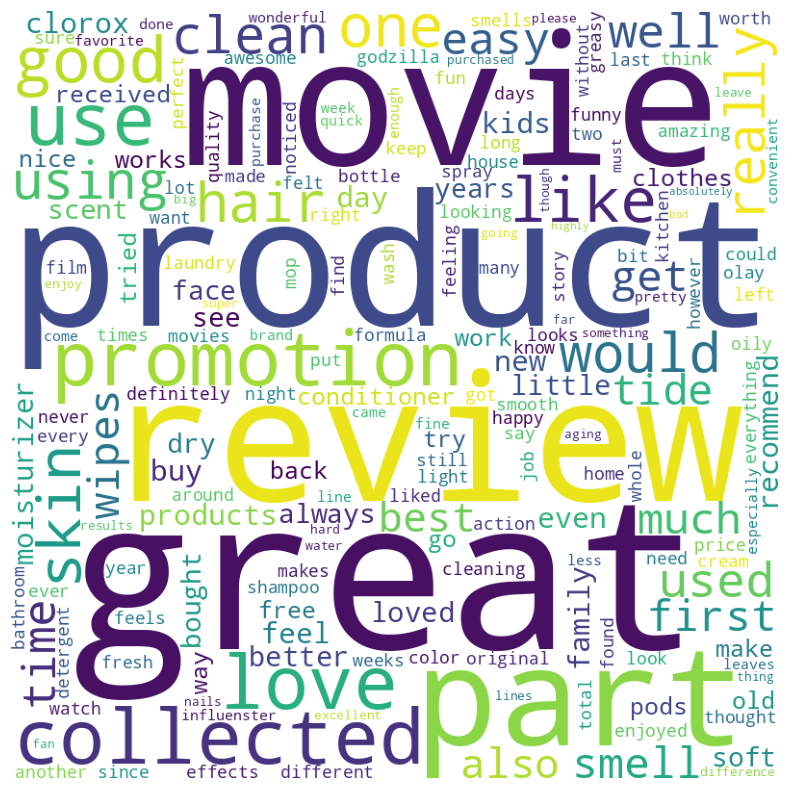

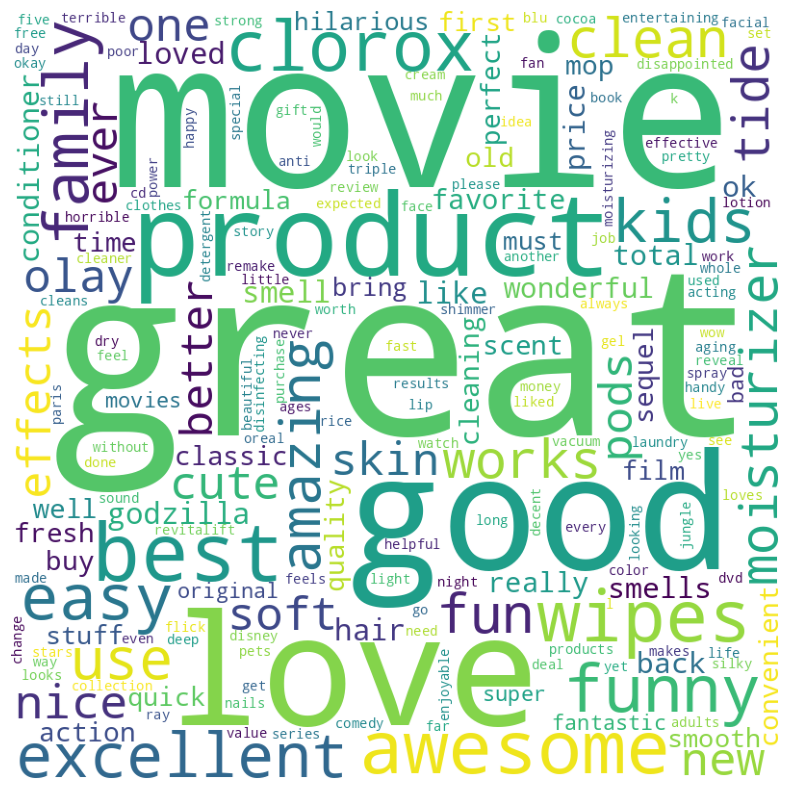

In [33]:
# Hacer una nube de palabras. WordCloud
wordTextCloud = WordCloud(width=800, height=800, background_color='white', min_font_size=10).generate_from_frequencies(wordsText)
wordTitleCloud = WordCloud(width=800, height=800, background_color='white', min_font_size=10).generate_from_frequencies(wordsTitle)
plt.figure(figsize=(10,10))
plt.imshow(wordTextCloud)
plt.axis('off')
plt.show()

print()

plt.figure(figsize=(10,10))
plt.imshow(wordTitleCloud)
plt.axis('off')
plt.show()


In [36]:


# Descargar los recursos necesarios
nltk.download('sentiwordnet')
nltk.download('wordnet')

# Ejemplo de tu lista de palabras
wordsText_List = list(wordsText.keys())
wordsTitle_List = list(wordsTitle.keys())

# Unir las listas
words = wordsText_List + wordsTitle_List

# Clasificar las palabras como positivas o negativas usando SentiWordNet
positive_words = []
negative_words = []

for word in words:
    synsets = wn.synsets(word)
    if not synsets:
        continue

    synset = synsets[0]
    swn_synset = swn.senti_synset(synset.name())

    if swn_synset.pos_score() > swn_synset.neg_score():
        positive_words.append(word)
    elif swn_synset.neg_score() > swn_synset.pos_score():
        negative_words.append(word)

print("Positive Words:", positive_words)
print("Negative Words:", negative_words)


[nltk_data] Downloading package sentiwordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/sentiwordnet.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


Positive Words: ['love', 'good', 'hype', 'everyday', 'review', 'read', 'reviews', 'looking', 'lubricants', 'captivating', 'pleasant', 'lacked', 'lube', 'lubricant', 'like', 'highly', 'absolutely', 'thought', 'similar', 'buy', 'today', 'loved', 'fun', 'extremely', 'waste', 'got', 'surprise', 'wish', 'different', 'thinking', 'really', 'liking', 'enjoy', 'feel', 'enhancement', 'passion', 'honest', 'better', 'jelly', 'warm', 'know', 'tends', 'makes', 'pleasurable', 'drawback', 'find', 'hand', 'careful', 'due', 'surprisingly', 'actually', 'help', 'times', 'pretty', 'enjoyed', 'tend', 'awesome', 'excellent', 'intimate', 'easy', 'exceptional', 'exactly', 'says', 'yes', 'scent', 'best', 'able', 'mineral', 'completely', 'popular', 'jr', 'likes', 'cream', 'fragrance', 'soothing', 'compliments', 'favorite', 'creams', 'smile', 'broke', 'radiant', 'make', 'considered', 'delighted', 'stockpiled', 'convenient', 'loves', 'say', 'must', 'fabulous', 'happy', 'wonderful', 'new', 'mom', 'liked', 'expensiv

In [41]:
def sentiment_score(review, positive_words, negative_words):
    # Convertir la reseña a minúsculas y dividirla en palabras
    words = review.lower().split()

    wordCount = len(words)

    # Contar palabras positivas y negativas
    positive_count = sum(1 for word in words if word in positive_words)
    negative_count = sum(1 for word in words if word in negative_words)

    # Calcular el puntaje de sentimiento
    score = positive_count - negative_count
    score = score / wordCount if wordCount > 0 else 0
    return score

def classify_sentiment(score):
    if score > 0:
        return "Positive"
    elif score < 0:
        return "Negative"
    else:
        return "Neutral"

# Aplicar la función de clasificación a la columna 'reviews.text'
df['sentiment_score_text'] = df['reviews.text'].apply(lambda x: sentiment_score(x, positive_words, negative_words))
df['sentiment_text'] = df['sentiment_score_text'].apply(classify_sentiment)

# Aplicar la función de clasificación a la columna "reviews.title"
df['sentiment_score_title'] = df['reviews.title'].apply(lambda x: sentiment_score(x, positive_words, negative_words))
df['sentiment_title'] = df['sentiment_score_title'].apply(classify_sentiment)



In [42]:
print(df[["sentiment_score_text", "sentiment_text"]].head(10))
print(df[["sentiment_score_title", "sentiment_title"]].head(10))

   sentiment_score_text sentiment_text
0              0.105263       Positive
1              0.333333       Positive
2              0.500000       Positive
3              0.000000        Neutral
4             -0.076923       Negative
5              0.285714       Positive
6             -0.055556       Negative
7             -0.055556       Negative
8              0.062500       Positive
9              0.294118       Positive
   sentiment_score_title sentiment_title
0                    1.0        Positive
1                    1.0        Positive
2                    1.0        Positive
3                   -1.0        Negative
4                   -1.0        Negative
5                    0.0         Neutral
6                   -1.0        Negative
7                    1.0        Positive
8                   -1.0        Negative
9                    1.0        Positive


In [45]:
# Calcular el puntaje general sumando los puntajes del título y del texto de la reseña
df['overall_sentiment_score'] = df['sentiment_score_text'] + df['sentiment_score_title']
df['overall_sentiment_score'] = df['overall_sentiment_score']/2

df['overall_sentiment_score'].head()

,overall_sentiment_score
0,0.552632
1,0.666667
2,0.750000
3,-0.500000
4,-0.538462


### Análizar la data
1. Los 10 productos de mejor calidad basado en las reseñas


In [47]:
# Calcular la puntuación media de sentimiento para cada producto
top_10_products = df.groupby('name')['overall_sentiment_score'].mean().sort_values(ascending=False).head(10)
print("Top 10 productos de mejor calidad:")
print(top_10_products)


Top 10 productos de mejor calidad:
name
Bosch 3912/B3915/3915 Miter Saw Replacement Dust Bag # 2610911939    1.000000
Sobe Lifewater Strawberry Dragonfruit - 0 Cal                        1.000000
Guitar, Keyboard, Drum Throne                                        1.000000
Wet N Wild Color Icon Glitter Single, Distortion                     0.812500
Nature's Path Honey Oat Crunch Flax Plus Granola Bars                0.750000
Lundberg Organic Cinnamon Toast Rice Cakes                           0.708333
Calvin Klein Secret Obsession Eau De Parfum                          0.708333
42 Dual Drop Leaf Table with 2 Madrid Chairs"                        0.687500
La Tortilla Factory Hand Made Style Tortillas Flour                  0.666667
Wilton Black Dots Standard Baking Cups                               0.666667
Name: overall_sentiment_score, dtype: float64


2. Los 10 productos de menor calidad dado su reseña


In [48]:
# Calcular la puntuación media de sentimiento para cada producto
bottom_10_products = df.groupby('name')['overall_sentiment_score'].mean().sort_values().head(10)
print("Top 10 productos de menor calidad:")
print(bottom_10_products)

Top 10 productos de menor calidad:
name
99179 - Fit System 01-05 Civic Replacement Mirror Glass, Driver Side - check description for fitment details   -0.571429
Udi's Pepperoni Pizza                                                                                          -0.520000
Honey Bunches Of Oats Honey Roasted, 14.5 Oz.                                                                  -0.450000
Crystal Key Table Lamp - Safavieh174                                                                           -0.346491
Cantu Coconut Milk Shine Hold Mist - 8oz                                                                       -0.234949
Gone Fishing Titanized Fisherman Pliers with Braid Cutter                                                      -0.225000
Imagine Foods Organic Low Sodium Free Range Chicken Broth                                                      -0.208333
Sunbrella174 Spectrum Outdoor 2-Piece Square Throw Pillow Set - Blue                                           -0

3.  Los usuarios que dan la mayor cantidad de reseñas a distintos productos

In [49]:
# Contar la cantidad de reseñas por usuario
top_users = df.groupby('reviews.username')['name'].nunique().sort_values(ascending=False).head(10)
print("Top 10 usuarios que reseñan más productos:")
print(top_users)


Top 10 usuarios que reseñan más productos:
reviews.username
An anonymous customer    75
Mike                     29
Chris                    27
Anonymous                26
Sandy                    23
John                     23
Lisa                     22
Rick                     22
Mimi                     20
James                    19
Name: name, dtype: int64


4. Los usuarios que más reseñas negativas y positivas dan en promedio

In [51]:
# Calcular la cantidad de reseñas positivas y negativas por usuario
user_sentiment = df.groupby('reviews.username')['overall_sentiment_score'].mean().sort_values(ascending=False)
top_positive_users = user_sentiment.head(10)
top_negative_users = user_sentiment.tail(10)

print("Top 10 usuarios con reseñas más positivas en promedio:")
print(top_positive_users)
print()

print("Top 10 usuarios con reseñas más negativas en promedio:")
print(top_negative_users)


Top 10 usuarios con reseñas más positivas en promedio:
reviews.username
33Mirah          1.0
spoooks          1.0
Elmer            1.0
il_coff          1.0
jaborronreyes    1.0
TLeigh           1.0
mickie           1.0
nonono           1.0
slimeaso         1.0
Icu2x            1.0
Name: overall_sentiment_score, dtype: float64

Top 10 usuarios con reseñas más negativas en promedio:
reviews.username
ZaZa         -0.700000
Georgia2     -0.700000
RickyLee     -0.714286
momAZ        -0.750000
dt21         -0.750000
Mom63        -0.750000
JLGreg       -0.750000
4iambatman   -0.785714
Lifesaver    -0.833333
Rosbud1      -0.875000
Name: overall_sentiment_score, dtype: float64


5. Los productores que tienen productos de mejor calidad

In [52]:
# Calcular la puntuación media de sentimiento para cada productor
top_producers = df.groupby('manufacturer')['overall_sentiment_score'].mean().sort_values(ascending=False).head(10)
print("Top 10 productores con productos de mejor calidad:")
print(top_producers)


Top 10 productores con productos de mejor calidad:
manufacturer
Bosch                             1.000000
Music People                      1.000000
Pepsi                             1.000000
Markwins Beauty Products, Inc.    0.812500
Lundberg                          0.708333
Calvin Klein                      0.708333
La Tortilla Fac                   0.666667
Wilton                            0.666667
Parfums De Coeur Ltd              0.642857
STACY'S PITA CHIPS                0.619048
Name: overall_sentiment_score, dtype: float64


6. Los productores que tienen productos de peor calidad


In [53]:
# Calcular la puntuación media de sentimiento para cada productor
bottom_producers = df.groupby('manufacturer')['overall_sentiment_score'].mean().sort_values().head(10)
print("Top 10 productores con productos de peor calidad:")
print(bottom_producers)


Top 10 productores con productos de peor calidad:
manufacturer
K Source                    -0.571429
Udi's                       -0.520000
Post Consumer Brands, LLC   -0.450000
Cantu Shea Butter           -0.234949
TRADEMARK GAMES  INC        -0.225000
Imagine                     -0.208333
Pillow Perfect              -0.204545
NATRALIA                    -0.200000
Palladio                    -0.166667
Stanley Hardware            -0.151042
Name: overall_sentiment_score, dtype: float64


7. Distribución de Sentimientos

In [54]:
# Contar cuántas reseñas caen en cada categoría de sentimiento
sentiment_distribution = df['overall_sentiment_score'].apply(classify_sentiment).value_counts()
print("Distribución de sentimientos:")
print(sentiment_distribution)

Distribución de sentimientos:
overall_sentiment_score
Positive    55439
Negative    10639
Neutral      4966
Name: count, dtype: int64


8. Promedio de Calificaciones por Producto

In [55]:
# Calcular el promedio de calificación para cada producto
average_rating_by_product = df.groupby('name')['reviews.rating'].mean().sort_values(ascending=False).head(10)
print("Promedio de calificaciones por producto:")
print(average_rating_by_product)


Promedio de calificaciones por producto:
name
bareMinerals Original Foundation Broad Spectrum Spf 15, Medium        5.0
Isoplus Oil Sheen Hair Spray                                          5.0
Heinz Tomato Ketchup, 38oz                                            5.0
Heiress (dvd)                                                         5.0
Herbatint 9dr Copperish Gold                                          5.0
Hex Performance Free + Clear Advanced Laundry Detergent - 35 Loads    5.0
The Honest Company Bathroom Cleaner                                   5.0
Honey Bunches Of Oats Honey Roasted, 14.5 Oz.                         5.0
The Honest Company Bar Soap, Lavender                                 5.0
Hubba Bubba Bubble Tape - 2pk                                         5.0
Name: reviews.rating, dtype: float64


9. Productos con Mayor Cantidad de Reseñas

In [56]:
# Contar la cantidad de reseñas por producto
most_reviewed_products = df['name'].value_counts().head(10)
print("Productos con más reseñas:")
print(most_reviewed_products)


Productos con más reseñas:
name
Clorox Disinfecting Wipes Value Pack Scented 150 Ct Total                         8606
The Secret Life Of Pets (4k/uhd + Blu-Ray + Digital)                              5510
Independence Day Resurgence (4k/uhd + Blu-Ray + Digital)                          3609
Tide Original Liquid Laundry Detergent - 100 Oz                                   3498
Godzilla 3d Includes Digital Copy Ultraviolet 3d/2d Blu-Ray/dvd                   3330
Olay Total Effects Daily Moisturizer, 7-In-1 Anti-Aging, 0.5oz                    2766
The Jungle Book (blu-Ray/dvd + Digital)                                           2489
L'or233al Paris Elvive Extraordinary Clay Rebalancing Conditioner - 12.6 Fl Oz    2288
L'oreal Paris Revitalift Triple Power Deep-Acting Moisturizer                     2286
Clorox Disinfecting Bathroom Cleaner                                              2093
Name: count, dtype: int64


10. Usuarios Más Activos en Reseñas

In [57]:
# Contar la cantidad de reseñas por usuario
most_active_users = df['reviews.username'].value_counts().head(10)
print("Usuarios más activos en reseñas:")
print(most_active_users)


Usuarios más activos en reseñas:
reviews.username
An anonymous customer    421
Anonymous                113
Mike                     105
Chris                     88
ByAmazon Customer         58
Dave                      57
John                      49
Rick                      41
James                     32
Robert                    31
Name: count, dtype: int64


11. Productos con Mayor Variabilidad en Sentimiento

In [58]:
# Calcular la desviación estándar del sentimiento para cada producto
products_with_highest_variability = df.groupby('name')['overall_sentiment_score'].std().sort_values(ascending=False).head(10)
print("Productos con mayor variabilidad en sentimiento:")
print(products_with_highest_variability)


Productos con mayor variabilidad en sentimiento:
name
Bestway Rip Tide SUP, 10' x 30 x 4""                                       0.507635
Toy Story Kids' Woody Accessory Kit                                        0.489810
Annie's Homegrown Deluxe Elbows & Four Cheese Sauce                        0.483190
Progresso Vegetable Classics 99% Fat Free Lentil Soup                      0.478714
Snyder's Of Hanover Chocolate Covered Pretzels Dark Chocolate Mini Dips    0.473181
Plano Mini-Magnum 13-Compartment Tackle Box                                0.470694
Chips Deluxe Soft 'n Chewy Cookies                                         0.451788
Adesso Oslo Floor Lamp - White                                             0.447834
Voortman Sugar Free Fudge Chocolate Chip Cookies                           0.447016
Sebastian Halo Mist UV Filter Weightless Shine Spray                       0.424264
Name: overall_sentiment_score, dtype: float64


12. Productos con la Mayor Cantidad de Reseñas Extremas (Positivas o Negativas)


In [59]:
# Contar reseñas extremadamente positivas y negativas por producto
extreme_reviews = df[(df['overall_sentiment_score'] >= 0.9) | (df['overall_sentiment_score'] <= -0.9)]
extreme_reviews_count = extreme_reviews['name'].value_counts().head(10)
print("Productos con mayor cantidad de reseñas extremas (positivas o negativas):")
print(extreme_reviews_count)


Productos con mayor cantidad de reseñas extremas (positivas o negativas):
name
Tostitos Bite Size Tortilla Chips                           6
Cheetos Crunchy Flamin' Hot Cheese Flavored Snacks          4
Chester's Cheese Flavored Puffcorn Snacks                   4
Cinnamon Toast Crunch                                       3
Independence Day Resurgence (4k/uhd + Blu-Ray + Digital)    3
Hormel Chili, No Beans                                      3
International Delight Hazelnut Creamer, 24ct singles        3
Opti-Free Puremoist Disinfecting Solution 10fl Oz           2
Bounce Dryer Sheets, Fresh Linen, 160 sheets                2
Nivea Extended Moisture Body Lotion, 16.9fl Oz (500ml)      2
Name: count, dtype: int64


13. Usuarios que Dan Reseñas Extremas (Positivas o Negativas)

In [60]:
# Contar reseñas extremadamente positivas y negativas por usuario
extreme_user_reviews_count = extreme_reviews['reviews.username'].value_counts().head(10)
print("Usuarios que dan mayor cantidad de reseñas extremas (positivas o negativas):")
print(extreme_user_reviews_count)


Usuarios que dan mayor cantidad de reseñas extremas (positivas o negativas):
reviews.username
Ada          2
Will         2
Sandawong    1
Cheryl       1
GRAM         1
Elmer        1
Hoozeluv     1
Great        1
Joanna       1
Princess     1
Name: count, dtype: int64


14. Distribución de Sentimientos por Categoría de Producto

In [61]:
# Promedio de sentimiento por categoría de producto
average_sentiment_by_category = df.groupby('categories')['overall_sentiment_score'].mean().sort_values(ascending=False).head(10)
print("Promedio de sentimiento por categoría de producto:")
print(average_sentiment_by_category)


Promedio de sentimiento por categoría de producto:
categories
Food,Packaged Foods,Drinks,Functional Beverages,Food & Beverage,Beverages,Water,Sports Drinks,UNNAV,Grocery                                                                                                                                                                                                                                                                                     1.000000
Pro Audio,Musical Instruments,Keyboards,Keyboard Accessories,Benches Stools,Benches Stools xwcssvqtrsraawryzftefeevc,Benches Stools xadxxaawtxeuuyyfwr,Keyboards & Accessories,Musical Instruments & Gear,Pianos, Keyboards & Organs,Parts & Accessories,Stools & Benches,Percussion,Stools & Thrones,Benches,Drum Thrones,Keyboard Benches,Drum Set Accessories,Equipment,Music Stands,Toys    1.000000
Home Improvement,Tools,Power Tool Accessories,Saw Accessories,Tools & Home Improvement,Power & Hand Tools,Power Tool Parts & Accessories,Saw Blades, Par

## **Imagine que usted es analista de negocios y que está realizando este análisis para el productor que tiene más productos con malas reseñas ¿Qué le propondría a esta empresa para mejorar sus productos? Puede basar su análisis en la frecuencia de las palabras de las opiniones.**

Como analista de negocios para una empresa con productos que tienen malas reseñas, aquí hay algunas recomendaciones basadas en el análisis de la frecuencia de palabras y los datos proporcionados:

### Recomendaciones para Mejorar Productos con Malas Reseñas

1. **Análisis de Comentarios Negativos:**
   - **Palabras Negativas Comunes:**
     Basado en la frecuencia de palabras, los términos más frecuentes en las reseñas parecen ser `great`, `product`, `movie`, `review`, etc. Sin embargo, las reseñas negativas pueden contener términos negativos no listados aquí. Es importante realizar un análisis de sentimientos más detallado para identificar términos negativos comunes en las malas reseñas.
   - **Temas Comunes:**
     Identifica temas recurrentes en las reseñas negativas. Las palabras frecuentes como `fit`, `problem`, `defective`, o `not` (que podrían no estar en tu lista) pueden indicar problemas comunes que los usuarios están experimentando.

2. **Mejora de la Calidad del Producto:**
   - **Revisar Productos con Peor Calidad:**
     Enfócate en los productos con las puntuaciones más bajas y revisa los comentarios para entender qué aspectos específicos están causando insatisfacción. Los productos con peores reseñas incluyen artículos como `Fit System 01-05 Civic Replacement Mirror Glass` y `Udi's Pepperoni Pizza`. Identifica los defectos comunes o áreas de mejora mencionadas en las reseñas.
   - **Actualizaciones y Mejoras:**
     Basado en los comentarios, realiza mejoras en la calidad del producto. Esto podría incluir mejoras en el diseño, funcionalidad, materiales, o incluso en el servicio al cliente.

3. **Estrategia de Comunicación:**
   - **Respuestas a Reseñas:**
     Implementa una estrategia proactiva para responder a las reseñas negativas. Agradece a los usuarios por sus comentarios y ofrece soluciones o compensaciones cuando sea posible. Esto no solo ayuda a mitigar la insatisfacción sino que también muestra a otros clientes que la empresa se preocupa por la calidad.

4. **Monitoreo y Ajustes Continuos:**
   - **Monitoreo de Reseñas:**
     Realiza un seguimiento continuo de las reseñas para evaluar si las mejoras están teniendo un impacto positivo. Utiliza herramientas de análisis de sentimientos para monitorear la evolución de la percepción del producto con el tiempo.
   - **Ajustes Basados en Datos:**
     Ajusta las estrategias de mejora basadas en el feedback recibido y las tendencias emergentes en las reseñas.

### Análisis de Datos de Productos y Usuarios

1. **Top 10 Productos de Mejor y Peor Calidad:**
   - **Productos con Mejor Calidad:**
     Enfócate en los productos que tienen las mejores calificaciones como `Bosch 3912/B3915/3915 Miter Saw Replacement Dust Bag` y `Sobe Lifewater Strawberry Dragonfruit`. Analiza qué características o prácticas de estos productos contribuyen a su alta calificación y considera aplicar estos factores a otros productos.
   - **Productos con Peor Calidad:**
     Para los productos con las peores calificaciones, como `Fit System 01-05 Civic Replacement Mirror Glass` y `Udi's Pepperoni Pizza`, realiza un análisis profundo de las quejas y busca patrones en las reseñas para implementar mejoras específicas.

2. **Usuarios con Mayor Cantidad de Reseñas:**
   - **Usuarios Activos:**
     Identifica los usuarios que han dejado más reseñas y analiza sus comentarios. Estos usuarios pueden proporcionar una perspectiva valiosa sobre los productos y las áreas que necesitan atención.

3. **Usuarios con Reseñas Más Positivas y Negativas:**
   - **Usuarios Positivos:**
     Los usuarios que tienden a dejar reseñas muy positivas pueden estar satisfechos con ciertos aspectos del producto. Estudia sus comentarios para identificar qué les gusta y trata de replicar esos aspectos en productos con menos calificaciones.
   - **Usuarios Negativos:**
     Los usuarios que dejan reseñas negativas pueden proporcionar información crítica sobre los puntos débiles. Considera implementar cambios basados en sus comentarios para mejorar la calidad general.

4. **Productores con Productos de Mejor y Peor Calidad:**
   - **Productores con Mejor Calidad:**
     Examina a los productores con mejores puntuaciones y analiza sus prácticas, estándares de calidad y procesos. Considera adoptar prácticas similares para otros productos.
   - **Productores con Peor Calidad:**
     Para los productores con puntuaciones más bajas, revisa sus procesos y busca áreas donde pueda haber deficiencias. Implementa cambios para abordar estos problemas y mejorar la calidad.

### Implementación de Cambios

1. **Estrategia de Mejora:**
   Implementa las recomendaciones basadas en el análisis de los datos. Asegúrate de realizar cambios graduales y medibles para evaluar el impacto de las mejoras.

2. **Comunicación con Clientes:**
   Mantén a los clientes informados sobre las mejoras realizadas y cómo sus comentarios están siendo considerados para mejorar la calidad del producto.

3. **Evaluación y Ajustes:**
   Realiza un seguimiento de la efectividad de las acciones implementadas y ajusta las estrategias según sea necesario basándote en el nuevo feedback recibido.

Este enfoque integral debería ayudar a la empresa a mejorar la calidad de sus productos y la satisfacción general de los clientes.